In [0]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from google.colab import drive

from keras.models import Sequential, Model, load_model
from keras.layers import UpSampling1D, Conv1D, Activation, BatchNormalization, Reshape, Dense, Input, LeakyReLU, Dropout, Flatten, ZeroPadding1D
from keras.optimizers import Adam
from keras.initializers import RandomNormal

import glob
from PIL import Image
import numpy as np
import os
import argparse
from ast import literal_eval

import os
from os import listdir
from os.path import isfile, join, isdir

import pandas as pd
import numpy as np
import time
import datetime
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import f1_score,recall_score,precision_score,classification_report, confusion_matrix

import matplotlib.pyplot as plt
from IPython.display import clear_output
keras.__version__

Using TensorFlow backend.


'2.2.5'

In [0]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
basePath ="/gdrive/My Drive/Truth_Predicter Project/data-deep-learning/v0.1/raw/brizio_test/ALL_EEG_CONCATENATED/"

eegDataTarget = pd.read_csv(basePath + "EEG_ALL_TARGET_CLEAN.csv", sep=',')
eegDataNotTarget = pd.read_csv(basePath + "EEG_ALL_NOT-TARGET.csv", sep=',')

del eegDataTarget["Unnamed: 0"]
del eegDataNotTarget["Unnamed: 0"]

eegDataTarget.head()
eegDataNotTarget.head()

,Time,TP9,AF7,AF8,TP10
0,-1000.00000,-0.57267,0.27069,2.31811,1.96553
1,-996.09375,-2.58709,-1.74400,1.10914,2.76930
2,-992.18750,-2.98983,-2.95284,3.52659,5.99061
3,-988.28125,-3.39258,-3.75874,-0.10002,3.97386
4,-984.37500,-6.61573,-4.16177,-3.32366,2.36007


In [0]:
basePath ="/gdrive/My Drive/Truth_Predicter Project/data-deep-learning/v0.1/raw/brizio_test/ALL_SPECTRA_CONCATENATED/"

spectraDataTarget = pd.read_csv(basePath + "SPECTRA_ALL_TARGET_CLEAN.csv", sep=',')
spectraDataNotTarget = pd.read_csv(basePath + "SPECTRA_ALL_NOT-TARGET.csv", sep=',')

del spectraDataTarget["Unnamed: 0"]
del spectraDataNotTarget["Unnamed: 0"]

spectraDataTarget.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,16.274,20.8240,23.058,24.255,21.9940,19.8720,18.7450,15.1280,12.9930,11.1330,4.8793,-0.51339,3.4659,4.5387,2.0692,0.78464,2.0352,-0.63959,-1.21450,-3.124000,-4.67530,-3.0094,0.30278,-3.9648,-9.2800,-4.22210,-1.74340,-9.883100,-5.30530,-5.61070,-6.7211,-5.9783,-3.1172,-3.3700,-5.7401,-4.1233,-5.28200,-6.1411,-8.9539,-9.8946,...,-11.6340,-9.0390,-14.1720,-13.0850,-18.2330,-10.366,-8.8150,-9.4636,-15.3770,-14.202,-12.5170,-12.1020,-13.779,-13.891,-17.2030,-18.548,-15.0100,-14.1200,-15.053,-18.1970,-21.9590,-20.649,-19.043,-23.188,-20.689,-24.485,-25.569,-26.722,-23.419,-22.891,-33.816,-25.940,-25.430,-28.845,-27.775,-32.800,-29.963,-29.619,-34.160,-36.617
1,33.442,30.8250,20.138,17.478,16.6850,12.5660,9.6236,3.6547,2.9065,2.7457,1.2874,-1.27960,1.6603,3.9557,3.2804,2.92630,2.9517,-1.32210,-1.95540,-0.636370,0.14353,5.2011,2.03580,-4.6783,-2.0461,-1.86300,-4.35240,-0.045534,0.54181,-0.67545,-4.0725,1.7857,6.1053,1.1133,-4.7364,-3.8023,0.68044,-2.0310,-4.5454,-3.3265,...,-6.7997,-8.8369,-3.1461,-4.9332,-3.7248,-7.329,-3.7389,2.4772,-3.8017,-15.116,-8.1173,-8.5667,-10.428,-11.786,-9.7058,-11.588,-9.3072,8.4251,10.754,-5.9629,-8.8188,-13.463,-13.009,-15.343,-16.399,-15.093,-13.616,-18.646,-11.182,-12.557,-18.580,-16.698,-17.246,-17.458,-19.257,-19.694,-18.511,-22.071,-13.304,-10.347
2,3.528,7.7536,8.874,10.687,9.6157,7.2881,4.8457,1.1340,-1.1578,-2.6900,-9.6530,-7.45530,-7.0738,-7.6099,-6.5245,-10.08300,-9.1900,-10.81000,-10.01900,-7.054800,-7.34230,-10.2750,-7.41440,-5.3613,-7.4548,-7.74430,-8.78540,-9.798600,-11.22200,-10.48100,-12.5270,-10.3210,-8.8115,-7.8075,-8.4878,-9.6802,-10.08200,-12.6030,-10.9440,-11.2880,...,-13.8650,-15.2100,-16.3850,-12.8970,-16.5810,-17.492,-15.1380,-15.0250,-13.8410,-15.715,-15.9240,-16.6520,-18.962,-16.197,-16.7070,-16.078,-16.3440,-20.5680,-18.681,-18.6290,-21.2060,-20.816,-22.216,-23.372,-22.577,-21.678,-23.538,-27.794,-29.752,-27.443,-25.562,-26.546,-30.320,-32.472,-30.509,-32.121,-34.990,-35.085,-34.937,-41.918
3,15.633,20.8880,22.985,23.526,21.7160,19.8580,18.7030,14.9620,10.6370,9.2255,6.1247,3.14350,3.0920,4.8859,1.9258,1.38040,4.1291,2.36000,1.79880,0.060743,-5.18560,-2.8232,-0.98498,-4.2310,-2.0811,0.07082,1.39380,-0.301860,-4.88710,-6.27660,-4.4066,-1.8790,-1.5415,-1.6648,-5.0813,-4.8887,-7.38300,-3.6586,-4.1787,-5.2993,...,-15.3110,-11.1950,-10.6310,-14.2190,-12.8730,-15.490,-14.1030,-12.0140,-12.1910,-10.883,-12.3810,-15.5920,-15.726,-13.142,-15.7550,-14.480,-15.0450,-17.1230,-15.720,-13.9740,-16.4640,-20.312,-19.227,-22.047,-22.736,-19.299,-20.363,-23.490,-22.374,-28.670,-27.322,-27.008,-24.721,-28.415,-32.545,-33.887,-34.282,-32.898,-29.282,-35.966
4,22.552,21.3540,18.867,20.497,16.6960,17.9840,17.7810,14.1980,15.3400,13.2780,11.4240,10.36900,5.7686,7.8935,2.8671,-1.47510,2.4177,2.47080,0.37056,1.187100,-4.26430,-4.1510,-1.51100,-5.7440,-2.8250,-1.21360,0.40071,-1.583900,-3.36330,-5.05660,-4.3780,-7.7501,-6.5920,-1.7733,-5.6388,-9.3224,-10.32400,-8.7882,-6.2488,-7.0919,...,-10.4740,-12.7910,-13.0050,-10.4450,-13.2380,-10.800,-14.4830,-11.1500,-11.0310,-13.894,-14.2340,-19.9650,-17.117,-16.315,-18.3280,-15.928,-19.2780,-16.7400,-21.042,-18.8470,-20.3700,-16.100,-19.042,-16.672,-20.785,-19.210,-17.841,-25.605,-24.760,-25.028,-24.524,-28.194,-30.741,-30.071,-28.951,-33.409,-29.546,-35.448,-30.289,-32.187


In [0]:
windowStart = 0
windowEnd = 3000
numberOfSeconds = (windowEnd - windowStart)/ 1000
n_features = numberOfSeconds * 256
numberOfSamplesPerRound = int(numberOfSeconds * 256)

eegDataTargetReduced = eegDataTarget[(eegDataTarget["Time"] >= windowStart) & (eegDataTarget["Time"] < windowEnd)]
eegDataNotTargetReduced = eegDataNotTarget[(eegDataNotTarget["Time"] >= windowStart) & (eegDataNotTarget["Time"] < windowEnd)]

del eegDataNotTargetReduced["Time"]
del eegDataTargetReduced["Time"]

print(numberOfSamplesPerRound)

768


In [0]:
cols = eegDataTargetReduced.columns
eegDataTargetReducedNorm = eegDataTargetReduced

cols = eegDataNotTargetReduced.columns
eegDataNotTargetReducedNorm = eegDataNotTargetReduced

In [0]:
eegDataTargetReducedNumpy = np.array(eegDataTargetReducedNorm.values)
numberOfTargetValues = int(eegDataTargetReducedNorm.shape[0]/numberOfSamplesPerRound)
trainingTargetSet = np.array(np.array_split(eegDataTargetReducedNumpy, eegDataTargetReducedNorm.shape[0]/numberOfSamplesPerRound))

eegDataNotTargetReducedNumpy = np.array(eegDataNotTargetReducedNorm.values)
trainingNotTargetSet = np.array(np.array_split(eegDataNotTargetReducedNumpy, eegDataNotTargetReducedNorm.shape[0]/numberOfSamplesPerRound))

numOfTargets = trainingTargetSet.shape[0]

trainingTargetSet = trainingTargetSet[0:numOfTargets - 1]
trainingNotTargetSet = trainingNotTargetSet[0:numOfTargets - 1]

print("Target set - Training ", trainingTargetSet.shape)
print("Not target set - training ", trainingNotTargetSet.shape)

Target set - Training  (804, 768, 4)
Not target set - training  (804, 768, 4)


In [0]:
spectraDataTargetReducedNumpy = np.array(spectraDataTarget.values)
trainingSpectraTargetSet = np.array(np.array_split(spectraDataTargetReducedNumpy.T, spectraDataTarget.shape[0]/4,axis=1))

trainingSpectraTargetSet = trainingSpectraTargetSet[0:trainingSpectraTargetSet.shape[0] - 1]

spectraDataNotTargetReducedNumpy = np.array(spectraDataNotTarget.values)
trainingSpectraNotTargetSet = np.array(np.array_split(spectraDataNotTargetReducedNumpy.T, spectraDataNotTarget.shape[0]/4,axis=1))
trainingSpectraNotTargetSet = trainingSpectraNotTargetSet[0:numOfTargets - 1]

trainingSpectraTargetSet = np.delete(trainingSpectraTargetSet, -1, 1)
trainingSpectraNotTargetSet = np.delete(trainingSpectraNotTargetSet, -1, 1)
trainingSpectraNotTargetSet.shape

(804, 128, 4)

In [0]:
trainingTargetSetFull = trainingTargetSet
#trainingTargetSetFull = np.column_stack((trainingTargetSet, trainingSpectraTargetSet))
#trainingNotTargetSetFull = np.column_stack((trainingNotTargetSet, trainingSpectraNotTargetSet))
#print([trainingTargetSetFull.shape,trainingNotTargetSetFull.shape])



# SHUFFLING THE DATASETS
np.random.shuffle(trainingTargetSetFull)
#np.random.shuffle(trainingNotTargetSetFull)

#Taking 100 targets and 200 notTargets for final test predictions
numTargetFinalTest = 100
numNotTargetFinalTest = 100
targetSetFinalTest = trainingTargetSetFull[0:numTargetFinalTest]
#notTargetSetFinalTest = trainingNotTargetSetFull[0:numNotTargetFinalTest]
print(targetSetFinalTest.shape)
#print(notTargetSetFinalTest.shape)

trainingTargetSet = trainingTargetSetFull[numTargetFinalTest:] 
#trainingNotTargetSet = trainingNotTargetSetFull[numNotTargetFinalTest:] 
#print(trainingTargetSet.shape)
#print(trainingNotTargetSet.shape)
numberOfTargetValues = trainingTargetSet.shape[0]

numberOfNotTarget = numberOfTargetValues
print("Num Not Target ", numberOfNotTarget)

#here EQUIPROBABILITY
trainingNotTargetSet = trainingNotTargetSet[0:numberOfNotTarget]

#FLATTENING
'''
trainingTargetSetReshaped = []
trainingNotTargetSetReshaped = []
for i in range(numberOfTargetValues):
    trainingTargetSetReshaped.append(trainingTargetSet[i].flatten())
    
for i in range(numberOfNotTarget):
    trainingNotTargetSetReshaped.append(trainingNotTargetSet[i].flatten())
    
trainingTargetSetReshaped = np.array(trainingTargetSetReshaped)
trainingNotTargetSetReshaped = np.array(trainingNotTargetSetReshaped)

print(trainingTargetSetReshaped.shape)
print(trainingNotTargetSetReshaped.shape)
'''
print("")

(100, 768, 4)
Num Not Target  704



In [0]:
#TRAINING SET DEFINING

numberOfNotTarget = numberOfTargetValues
print(numberOfTargetValues) 
print(numberOfNotTarget) 

#WITHOUT USING VALIDATION SET

trainingTargetSetReshaped = trainingTargetSet
trainingNotTargetSetReshaped = trainingNotTargetSet

trainingCNNShape = trainingTargetSetReshaped.shape

print(trainingTargetSetReshaped.shape)
print(trainingNotTargetSetReshaped.shape)

704
704
(704, 768, 4)
(704, 768, 4)


In [0]:
trainingSet = trainingTargetSetReshaped

#LABEL CONCATENATING AND SHUFFLING
'''
trainingSet = np.concatenate((trainingTargetSetReshaped,trainingNotTargetSetReshaped))

trainingSetLabelsOnes = np.ones((numberOfTargetValues,), dtype=int)
trainingSetLabelsZeros = np.zeros((numberOfNotTarget,), dtype=int)
trainingLabels = np.concatenate((trainingSetLabelsOnes,trainingSetLabelsZeros))
'''

print(trainingSet.shape)
#print(trainingLabels.shape)

(704, 768, 4)


In [0]:
class DCGAN:
    def __init__(self,trainingSet):
        self.noiseSize = 80
        self.upsample_layers = 3
        self.starting_filters = 64
        self.kernel_size = 3
        self.channels = 4
        self.trainingSet = trainingSet
        self.generatorName = "generat18.h5"
        self.discriminatorName = "discrim18.h5"
        self.discriminator_path = "/gdrive/My Drive/Truth_Predicter Project/data-deep-learning/v0.1/raw/brizio_test/models/" + self.discriminatorName
        self.generator_path = "/gdrive/My Drive/Truth_Predicter Project/data-deep-learning/v0.1/raw/brizio_test/models/" + self.generatorName
        self.output_directory = "/gdrive/My Drive/Truth_Predicter Project/data-deep-learning/v0.1/raw/brizio_test"

    def build_generator(self):
        noise_shape = (self.noiseSize,)

        # This block of code can be a little daunting, but essentially it automatically calculates the required starting
        # array size that will be correctly upscaled to our desired image size.
        #
        # We have 5 Upsample2D layers which each double the images width and height, so we can determine the starting
        # x size by taking (x / 2^upsample_count) So for our target image size, 256x192, we do the following:
        # x = (192 / 2^5), y = (256 / 2^5) [x and y are reversed within the model]
        # We also need a 3rd dimension which is chosen relatively arbitrarily, in this case it's 64.
        
        model = Sequential()
        
        init = RandomNormal(mean=0.0, stddev=0.02)
        
        numberOfDenseNodes = self.starting_filters * (self.trainingSet.shape[1] // (2 ** self.upsample_layers))
        
        model.add(Dense(numberOfDenseNodes, activation="relu", input_shape=noise_shape,kernel_initializer=init))
        
        model.add(Reshape(((self.trainingSet.shape[1] // (2 ** self.upsample_layers)), self.starting_filters)))
        
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling1D())  # 112 -> 224 || 96 -> 192
        model.add(Conv1D(128, kernel_size=self.kernel_size, padding="same"))
        model.add(Conv1D(256, kernel_size=self.kernel_size, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling1D())  # 224 -> 448 || 192 -> 384
        model.add(Conv1D(128, kernel_size=self.kernel_size, padding="same"))
        model.add(Conv1D(256, kernel_size=self.kernel_size, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling1D())  # 448 -> 896 || 384 -> 768
        model.add(Conv1D(64, kernel_size=self.kernel_size, padding="same"))
        model.add(Conv1D(64, kernel_size=self.kernel_size, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv1D(32, kernel_size=self.kernel_size, padding="same"))
        model.add(Conv1D(32, kernel_size=self.kernel_size, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv1D(self.channels, kernel_size=self.kernel_size, padding="same"))

        model.summary()

        noise = Input(shape=noise_shape)
        timeAndSpectra = model(noise)

        return Model(noise, timeAndSpectra)

      
    def build_discriminator(self):

        time_spectra_shape = (self.trainingSet.shape[1], self.channels)

        model = Sequential()

        model.add(Conv1D(32, kernel_size=self.kernel_size, strides = 1, input_shape = time_spectra_shape, padding = "same"))  # 896 -> 448 || 768 -> 384
        model.add(Conv1D(32, kernel_size=self.kernel_size, strides = 1, input_shape = time_spectra_shape, padding = "same"))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.25))

        model.add(Conv1D(64, kernel_size=self.kernel_size, strides=1, padding="same"))  # 448 -> 224 || 384 -> 192
        model.add(Conv1D(64, kernel_size=self.kernel_size, strides=1, padding="same"))
        #model.add(ZeroPadding1D(padding=((0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv1D(128, kernel_size=self.kernel_size, strides=1, padding="same"))  # 224 -> 112 || 192 -> 96
        model.add(Conv1D(128, kernel_size=self.kernel_size, strides=1, padding="same")) 
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        timeAndSpectra = Input(shape = time_spectra_shape)
        validity = model(timeAndSpectra)

        return Model(timeAndSpectra, validity)

      
    def build_gan(self):
        optimizer = Adam(0.0002, 0.5)

        # See if the specified model paths exist, if they don't then we start training new models

        if os.path.exists(self.discriminator_path) and os.path.exists(self.generator_path):
            self.discriminator = load_model(self.discriminator_path)
            self.generator = load_model(self.generator_path)
            print("Loaded models...")
        else:
            self.discriminator = self.build_discriminator()
            self.discriminator.compile(loss='binary_crossentropy',
                                       optimizer=optimizer,
                                       metrics=['accuracy'])

            self.generator = self.build_generator()
            self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # These next few lines setup the training for the GAN model
        z = Input(shape=(self.noiseSize,))
        timeAndSpectra = self.generator(z)

        self.discriminator.trainable = False

        valid = self.discriminator(timeAndSpectra)

        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss, optimizer=optimizer)
        #self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def wasserstein_loss(self, y_true, y_pred):
        return keras.backend.mean(y_true * y_pred)
    
    
    def smooth_positive_labels(self,y):
        return y - 0.07 + (np.random.random(y.shape) * 0.15)
    
    
    # randomly flip some labels
    def noisy_labels(self,y, p_flip):
        # determine the number of labels to flip
        n_select = int(p_flip * y.shape[0])
        # choose labels to flip
        flip_ix = np.random.choice([i for i in range(y.shape[0])], size=n_select)
        # invert the labels in place
        y[flip_ix] = 1 - y[flip_ix]
        return y
    
    
    def train(self, batch_size=64, save_interval=5000,epochs = 50000):
        self.build_gan()
        
        X_train = self.trainingSet
        
        print("Training Data Shape: ", X_train.shape)

        half_batch = batch_size // 2

        for epoch in range(epochs):
            # Train Generator
            noise = np.random.normal(0, 0.002, (batch_size, self.noiseSize))
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            timeAndSpectraArray = X_train[idx]

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 0.002, (half_batch, self.noiseSize))
            gen_time_and_spectra_array = self.generator.predict(noise)
            
            # Train the discriminator (real classified as ones and generated as zeros)
            
            # generate 'real' class labels (1)
            y = np.ones((half_batch,1))
            # smooth labels
            #y = self.smooth_positive_labels(y)
            
            y_zeros = np.zeros((half_batch, 1))
            
            
            if epoch % 100 == 0:
                # high number of noisy labels in rare occasions to trick a LOT more the discriminator
                y = self.noisy_labels(y, 0.2)
                y_zeros = self.noisy_labels(y_zeros, 0.2)
            else:
                # low number of noisy labels almost always occasions to trick a BIT more the discriminator
                y = self.noisy_labels(y, 0.05)
                y_zeros = self.noisy_labels(y_zeros, 0.05)
            
            
            d_loss_real = self.discriminator.train_on_batch(timeAndSpectraArray, y)
            d_loss_fake = self.discriminator.train_on_batch(gen_time_and_spectra_array, y_zeros)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # If at save interval => save generated image samples, save model files
            if epoch % (save_interval) == 0:
                print("GENERATED")
                plt.figure(figsize=(8,6))
                plt.plot(gen_time_and_spectra_array[10])
                plt.show()
                
                print("REAL")
                plt.figure(figsize=(8,6))
                plt.plot(timeAndSpectraArray[10])
                plt.show()
                # Print progress
                print(f"{epoch} [D loss: {d_loss[0]} | D Accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")
                
                #self.save_imgs(epoch)

                save_path = self.output_directory + "/models"
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                
                self.discriminator.save(save_path + "/" + self.discriminatorName)
                self.generator.save(save_path + "/" + self.generatorName)

                
    def gene_time_and_spectra(self, count):
        # Generate time and spectra from the currently loaded model
        noise = np.random.normal(0, 0.002, (count, self.noiseSize))
        generated =  self.generator.predict(noise)
        return generated

    def generate_data(self, count = 1):
        self.build_gan()

        # Generates (count) images from the model ensuring the discriminator scores them between the threshold values
        # and saves them

        timeAndSpectraArray = []
        for i in range(count):
          
            score = [0]
            timeAndSpectra = np.zeros((768,4))
            while score[0] > 0.075:
                timeAndSpectra = self.gene_time_and_spectra(1)
                score = self.discriminator.predict(timeAndSpectra)
                
            print(timeAndSpectra)
            
            print("Time and spectra found: ", score[0])
            timeAndSpectraArray.append(timeAndSpectra)

        timeAndSpectraArray = np.asarray(timeAndSpectraArray).squeeze()

        #print(timeAndSpectraArray.shape)
        
        for i, time_and_spectra in enumerate(timeAndSpectraArray):
            path = self.output_directory + "/GAN_generated/gan_generated_3"
            
            if not os.path.exists(path):
                os.makedirs(path)
            
            timeAndSpectraCSV = pd.DataFrame(time_and_spectra)
            timeAndSpectraCSV.to_csv(path + f"/generated_{i}.csv")






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Loaded models...
Training Data Shape:  (704, 768, 4)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


GENERATED


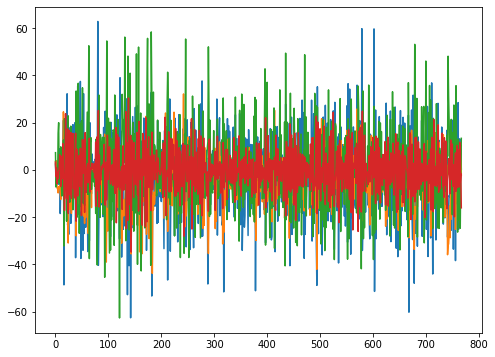

REAL


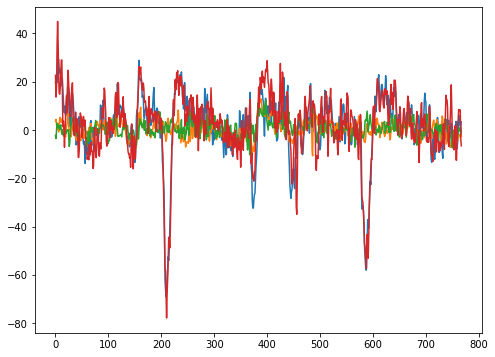

0 [D loss: 0.5775190591812134 | D Accuracy: 81.25] [G loss: 0.08418498188257217]


In [0]:
dcgan = DCGAN(trainingSet)

train = True

if train:
  dcgan.train()
else:
  dcgan.generate_data()